In [1]:
%pip install -U langchain langchain-core langchain-google-genai langgraph python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_google_genai import GoogleGenerativeAI
from dotenv import load_dotenv
import os

# --- 환경 설정 ---
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

if not GOOGLE_API_KEY:
    raise ValueError("환경 변수 'GOOGLE_API_KEY'를 설정해주세요. (.env 파일 확인)")
model = GoogleGenerativeAI(model="gemini-2.5-flash")
model.invoke("안녕하세요!")

'안녕하세요! 반갑습니다! 무엇을 도와드릴까요?'

In [11]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict을 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
        'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]

graph_builder = StateGraph(State)

In [12]:
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.

    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리.
          형식은 {"messages": [응답 메시지]}입니다.
    """
    return {"messages": [model.invoke(state["messages"])]}

graph_builder.add_node("generate", generate)

In [13]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

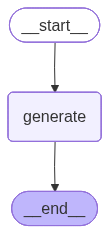

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))

except Exception:
    pass

In [15]:
response = graph.invoke({"messages": ["안녕하세요! 저는 이성용입니다."]})

print(type(response))

response

<class 'dict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다.', additional_kwargs={}, response_metadata={}, id='96d0e97f-ec69-40ca-81be-2ba44a2bcdbb'),
  HumanMessage(content='안녕하세요, 이성용님! 만나서 반갑습니다. 저는 OpenAI에서 훈련한 대규모 언어 모델입니다.\n\n무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='6df64196-9be1-4b48-bebc-be252bfb7269')]}

In [16]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 이성용입니다.', additional_kwargs={}, response_metadata={}, id='96d0e97f-ec69-40ca-81be-2ba44a2bcdbb'),
  HumanMessage(content='안녕하세요, 이성용님! 만나서 반갑습니다. 저는 OpenAI에서 훈련한 대규모 언어 모델입니다.\n\n무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='6df64196-9be1-4b48-bebc-be252bfb7269'),
  HumanMessage(content='제 이름을 아시나요?', additional_kwargs={}, response_metadata={}, id='bfdd27cd-0929-4b54-8ee9-0dab0150023f'),
  HumanMessage(content='네, 알고 있습니다. **이성용님**이십니다.\n\n제가 처음에 "안녕하세요, 이성용님!" 하고 인사드렸습니다. 맞으시죠?', additional_kwargs={}, response_metadata={}, id='738eca1c-1e9b-469c-98b0-27fa97b522e8')]}